# Analyze book data and create Figures 2 and 3

This also performs the statistical analyses and sets up the file for cluster analysis (run in R)

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #https://towardsdatascience.com/how-to-perform-exploratory-data-analysis-with-seaborn-97e3413e841d
from matplotlib import cm

import itertools
from itertools import combinations
import scipy
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

## Skip to analysis section if the raw dataset has already been processed


## Prepare raw data
#### From excel, save the csv to utf-8 then import, make sure col headings are good too

In [89]:
df = pd.read_csv('bookData.csv')
# check the data frame info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1013 entries, 0 to 1012
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   cataloger         1013 non-null   object
 1   bookid            1013 non-null   object
 2   count             1013 non-null   int64 
 3   title             1013 non-null   object
 4   author            997 non-null    object
 5   combinedName      980 non-null    object
 6   authorOfColor     1013 non-null   int64 
 7   nonPersonAuthor   1013 non-null   int64 
 8   yrpub             1013 non-null   object
 9   neighborhood      1013 non-null   object
 10  collection        1013 non-null   object
 11  age               1013 non-null   object
 12  type              1013 non-null   object
 13  category1         1013 non-null   object
 14  category1Code     1003 non-null   object
 15  category2         1013 non-null   object
 16  subjects          472 non-null    object
 17  deweywording  

In [90]:
#Convert Date to Number after removing the question marks (making them NaN)
df['yrpub'] = df['yrpub'].replace('?',None)
df['yrpub']=df['yrpub'].astype(int)
df.yrpub.unique()

array([2019, 2007, 2006, 1992, 1989, 1990, 1975, 2009, 2018, 1998, 1988,
       1991, 2010, 2017, 1996, 2013, 2003, 2011, 1999, 2008, 1993, 1986,
       1997, 2004, 2002, 2005, 2000, 1968, 2015, 2012, 1982, 2001, 1981,
       1962, 1987, 1964, 1984, 1985, 1974, 2014, 1946, 1960, 1970, 1950,
       1979, 1928, 1983, 1994, 1978, 1977, 1995, 1980, 1963, 2016, 1958,
       1976, 1967, 1965, 1971, 1969, 1966, 1954, 1961, 1959, 1973, 1949,
       1937, 1972])

###  Group the categorical and numeric columns

In [91]:
numerical = [
  'yrpub','count','authorOfColor','nonPersonAuthor'
]
categorical = [
  'neighborhood','collection','type','age','category1','category2','category1Code','languages','originalLang', 'combinedName'
]

bks = df[numerical + categorical]
bks.shape

(1013, 14)

In [92]:
bks['collection'].head()

0    CentralDistrict1
1    CentralDistrict1
2    CentralDistrict1
3    CentralDistrict1
4    CentralDistrict2
Name: collection, dtype: object

In [93]:
bks.yrpub.max()

2019

(1900.0, 2020.0)

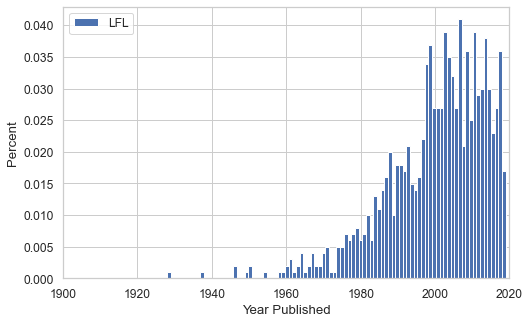

In [68]:
#'Density' Histogram of year published using mtlabplot
#yrhist = bks['yrpub'].plot.hist(bins=50)
#Same thing using seaborn
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    bks['yrpub'], norm_hist=True, kde=False, bins=92, hist_kws={"alpha": 1}
).set(xlabel='Year Published', ylabel='Percent')

plt.legend(labels=['LFL'])
#plt.legend('ABCDEF', ncol=2, loc='upper left')

plt.xlim(1900, 2020)

In [94]:
#export csv for use here and with SPL data in Get-SPL-data-by-hood ipynb file: 
bks.to_csv('LFL-books-years.csv', mode = 'w', index=False)

### If you are running the entire analysis for the first time, switch to the Get-SPL-data-by-hood Jupyter notebook in the publicLibraryComparison folder.
That creates several csv files need to make charts below. Specifically the percent fiction and percent juvenile charts.

# Start Analysis

In [2]:
#SKIP this cell if you are running the whole script from the start 
#Open LFL cleaned above data and the stat dataset.  These are combined in various ways below.

bks = pd.read_csv('LFL-books-years.csv',encoding='utf-8')
dfstats = pd.read_csv('lfl-stats.csv')
bksctstat = pd.read_csv('bkstats.csv',encoding='utf-8') #This file is created further down with book volumes
bks.head()

,yrpub,count,authorOfColor,nonPersonAuthor,neighborhood,collection,type,age,category1,category2,category1Code,languages,originalLang,combinedName
0,2019,1,0,1,Central District,CentralDistrict1,Nonfiction,Adult,Politics,Politics,POL,English,English,Human Rights Watch
1,2007,1,0,0,Central District,CentralDistrict1,Fiction,Adult,Religion,Religion,R,English,English,William P. Young
2,2006,1,0,0,Central District,CentralDistrict1,Fiction,Adult,Suspense,Suspense,SUS,English,English,Dick Couch
3,1992,1,0,0,Central District,CentralDistrict1,Fiction,Adult,Suspense,Suspense,SUS,English,English,James Grady
4,1989,1,0,0,Central District,CentralDistrict2,Fiction,Adult,Anthology/Essays/Short stories,Anthology/Essays/Short stories,AN,English,NaN,"Hollis Hodges, Loup Durand, Elliott Roosevelt ..."


# Figure 2 - Fiction and Reading Level Analysis

## Fiction by neighborhood

In [48]:
#Set up the Dataframe

#Groups count by Neighborhood, collection, and type (fiction or non fiction), calculate percent
bksfiction = bks.groupby(['neighborhood','collection', 'type'])['count'].sum().reset_index()
bksfiction['total'] = bksfiction.groupby('collection')['count'].transform('sum')
bksfiction['percent'] = bksfiction['count']/bksfiction['total']
#Check the dataframe manually and add in any collections that are only nonfiction with 0%. In this case, ColumbiaCity5 
zerorow = {'neighborhood': 'Columbia City', 'collection': 'ColumbiaCity5', 'type': 'Fiction', 'count':0,'total':7,'percent':0}
bksfiction = bksfiction.append(zerorow, ignore_index = True)

#Select fiction
fic = bksfiction.loc[bksfiction['type']=='Fiction'].copy() #adding the .copy() gets rid of the settingwithcopywarning


#Sort and reindex so that the chart goes low to high
fic['median'] = fic.groupby('neighborhood')['percent'].transform('median')
fic = fic.sort_values(by=['median'], ascending=True).reset_index()


In [49]:
#Are all 42 LFLs represented?
len(fic['collection'].unique())

42

In [36]:
#Set up table for Chi Square to compare fiction proportion between neighborhoods
fichood = fic.groupby('neighborhood').agg({'count':'sum', 'total': 'sum'}).reset_index()
fichood.head()
ficTotal = fichood['count'].sum()
totBks = fichood['total'].sum()
fichood['expCount']= (ficTotal*fichood['total'])/totBks #Only need if using chisquare, not chi2: expected value is row total times col total divided by grand total. Accounts for different number of books
fichood['nonficCount']= fichood['total'] - fichood['count']
fichood.head()

,neighborhood,count,total,expCount,nonficCount
0,Central District,59,93,61.877591,34
1,Columbia City,51,86,57.220138,35
2,Laurelhurst,63,91,60.546890,28
3,Montlake,34,81,53.893386,47
4,Northgate,143,240,159.684107,97


In [37]:
#Open SPL fiction dataframe from the Get-SPL-Book-Data-by-hood jupyter file
ficSPL = pd.read_csv('../publicLibraryComparison/SPL-fiction.csv',encoding='utf-8')
ficSPL.head(10)

,neighborhood,type,count,total,percent
0,Central District,Fiction,23003,49029,0.469171
1,Columbia City,Fiction,14870,26486,0.561429
2,Laurelhurst,Fiction,29836,50942,0.585686
3,Montlake,Fiction,7731,13001,0.594647
4,Northgate,Fiction,16174,27569,0.586673
5,Phinney-Greenwood,Fiction,22772,42934,0.530395
6,Queen Anne,Fiction,10197,18491,0.551457
7,Ravenna,Fiction,29569,51059,0.579114


In [38]:
#Get the medians from the LFL data (fic) and sort so that the points go to the right places
medians = fic[['neighborhood','median']].copy()
medians.drop_duplicates(inplace=True)
medians
ficSPLsorted = pd.merge(medians, ficSPL, on='neighborhood', how='inner')
ficSPLsorted.sort_values(by=['median'], ascending=True)
#ficSPLsorted = ficSPLsorted.fillna('1.2')
ficSPLsorted

,neighborhood,median,type,count,total,percent
0,Montlake,0.494286,Fiction,7731,13001,0.594647
1,Columbia City,0.562500,Fiction,14870,26486,0.561429
2,Central District,0.616667,Fiction,23003,49029,0.469171
3,Northgate,0.653846,Fiction,16174,27569,0.586673
4,Phinney-Greenwood,0.655172,Fiction,22772,42934,0.530395
5,Laurelhurst,0.699248,Fiction,29836,50942,0.585686
6,Queen Anne,0.807692,Fiction,10197,18491,0.551457
7,Ravenna,0.809524,Fiction,29569,51059,0.579114


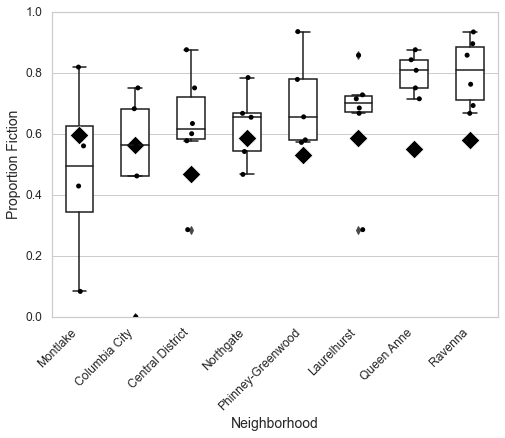

In [39]:
#Make the chart.


#Plots using Seaborn
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 8]})
bplot = sns.boxplot(y='percent', x='neighborhood', data=fic,
                 width=0.5)
#                 palette="colorblind")

#Remove default colors 
plt.setp(bplot.artists, edgecolor = 'k', facecolor='w')
plt.setp(bplot.lines, color='k')

# add stripplot to boxplot with Seaborn
bplot=sns.stripplot(y='percent', x='neighborhood', data=fic, 
                   jitter=True, 
                   marker='o', 
                   alpha=1,
                   color='black')

# SPL fiction percentages
bplot=sns.scatterplot(y='percent', x='neighborhood', data=ficSPLsorted, marker='D', color='#000000', s=175)


#Set y axis label and scale

bplot.set_ylabel("Proportion Fiction",
                fontsize=14)
bplot.set_xlabel("Neighborhood",
                fontsize=14)
bplot.set(ylim=(0, 1))

#rotate labels
for item in bplot.get_xticklabels():
    item.set_rotation(45)
    item.set_ha('right') #This sets horizontal alignment

plt.gcf().subplots_adjust(bottom=0.35) #makes room for the 'tall' x axis lables

#Save figure 
plt.savefig('../figures/fiction.eps')
plt.savefig('../figures/fiction.eps', dpi=300, format="eps")
plt.savefig('../figures/fiction.png', dpi=300, format="png")
    

In [40]:
#Chi Square
ficChi= fichood[['count','nonficCount']]
chi2, p, dof, ex = chi2_contingency(ficChi, correction=False) #using chi2 here rather than chisquare because including adult book rather than specifying distribution (expected values)
print("chi: ",chi2,"p-value: ",p,"degrees of freedom: ",dof)

chi:  52.96305594281427 p-value:  3.769937733782428e-09 degrees of freedom:  7


In [41]:
# gathering all combinations for post-hoc chi2
#Thanks to: https://neuhofmo.github.io/chi-square-and-post-hoc-in-python/
all_combinations = list(combinations(ficChi.index, 2))
print("Significance results:")
for comb in all_combinations:
    # subset df into a dataframe containing only the pair "comb"
    new_df = ficChi[(ficChi.index == comb[0]) | (ficChi.index == comb[1])]
    # running chi2 test
    chi2, p, dof, ex = chi2_contingency(new_df, correction=False)
    print(f"Chi2 result for pair {comb}: {chi2}, p-value: {p}")

Significance results:
Chi2 result for pair (0, 1): 0.3230619743209849, p-value: 0.569773295125018
Chi2 result for pair (0, 2): 0.6901351095411246, p-value: 0.4061184287559032
Chi2 result for pair (0, 3): 8.017396335454947, p-value: 0.004633012906564043
Chi2 result for pair (0, 4): 0.417958999636728, p-value: 0.5179572246030208
Chi2 result for pair (0, 5): 2.28478442309581, p-value: 0.1306482937282464
Chi2 result for pair (0, 6): 7.155374816223318, p-value: 0.007473967461251691
Chi2 result for pair (0, 7): 8.03180799537338, p-value: 0.00459629369788509
Chi2 result for pair (1, 2): 1.9012098672441384, p-value: 0.16794295890579794
Chi2 result for pair (1, 3): 5.010888776846421, p-value: 0.02518837245193884
Chi2 result for pair (1, 4): 0.002074857299923195, p-value: 0.9636684425361366
Chi2 result for pair (1, 5): 4.587102599194711, p-value: 0.03221342561660733
Chi2 result for pair (1, 6): 10.278319276038054, p-value: 0.0013460250345933098
Chi2 result for pair (1, 7): 11.450243299403814, p-

In [42]:
#Here's the list of neighborhoods corresponding to above. Bonferonni- 0.05/29=0.00172
#Different: Columbia City and Queen Anne + Ravenna
#Montlake is different than Phinney, Queen, Laurelhurst, and Ravenna. Northgate is different than Queen Anne and Ravenna.
fichood

,neighborhood,count,total,expCount,nonficCount
0,Central District,59,93,61.877591,34
1,Columbia City,51,86,57.220138,35
2,Laurelhurst,63,91,60.546890,28
3,Montlake,34,81,53.893386,47
4,Northgate,143,240,159.684107,97
5,Phinney-Greenwood,138,191,127.081935,53
6,Queen Anne,86,107,71.192498,21
7,Ravenna,100,124,82.503455,24


## Age by Neighborhood

In [28]:
bks.age.unique()

array(['Young Adult', 'Adult', 'Childrens'], dtype=object)

Text(0, 0.5, 'Number of books')

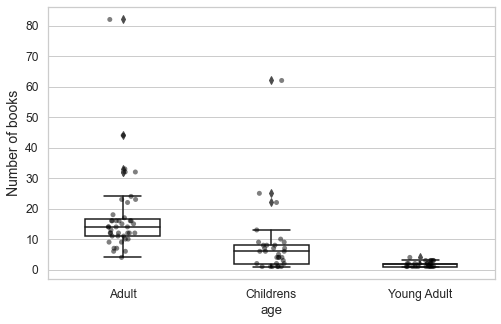

In [43]:
#Groups count by collection and age
bksage = bks.groupby(['neighborhood', 'collection','age'])['count'].sum().reset_index()
#bksage.head()

#Plots using Seaborn
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
bplot = sns.boxplot(y='count', x='age', data=bksage,
                 width=0.5)
#                 palette="colorblind")

#Remove default colors 
plt.setp(bplot.artists, edgecolor = 'k', facecolor='w')
plt.setp(bplot.lines, color='k')

# add stripplot to boxplot with Seaborn
bplot=sns.stripplot(y='count', x='age', data=bksage, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black')

bplot.set_ylabel("Number of books",
                fontsize=14)

### Juvenile books across neighborhoods
Appears SPL includes teen books in juvenile

In [51]:
#Set up the Dataframe for box and whisker

#Groups count by Neighborhood, collection, and type. 
bksjuvenile = bks.groupby(['neighborhood','collection', 'age'])['count'].sum().reset_index()

#Get the percent juvenile by calculating percent and subracting adult percent from 1
bksjuvenile['total'] = bksjuvenile.groupby('collection')['count'].transform('sum')
bksjuvenile['typepercent'] = bksjuvenile['count']/bksjuvenile['total']
bksjuvenile = bksjuvenile[bksjuvenile.age == 'Adult'] #Select only adult rows
bksjuvenile['juvpercent'] = 1 - bksjuvenile['typepercent'] #calculate juvenile percent, this also puts zero for LFLs with only adult books
bksjuvenile = bksjuvenile.drop(['age'], axis=1) #Drop this column, not needed anymore
bksjuvenile = bksjuvenile.rename(columns={"typepercent": "adultpercent"}) #rename this column since it only shows adult percent now
bksjuvenile = bksjuvenile.rename(columns={"count": "adultcount"})

#Sort and reindex so that the chart goes low to high
juv = bksjuvenile #create a new dataframe just to use an easier name
juv['median'] = juv.groupby('neighborhood')['juvpercent'].transform('median') #For Central, median is zero since three LFLs had zero juv books

juv = juv.sort_values(by=['median'], ascending=True).reset_index()


In [46]:
#Are all 42 LFLs represented?
len(juv['collection'].unique())

42

In [52]:
d = {'adultcount': ['sum'], 'total': ['sum']}
lflJPercent = juv.groupby('neighborhood').agg(d).reset_index() #create totals table
lflJPercent.columns = ['_'.join(col) for col in lflJPercent.columns.values] # flatten MultiIndex columns
lflJPercent = lflJPercent.rename(columns={"neighborhood_": "neighborhood"})
lflJPercent = lflJPercent.rename(columns={"adultcount_sum": "adultcount"})
lflJPercent = lflJPercent.rename(columns={"total_sum": "lfltotal"})
lflJPercent['juvpercent'] = 1 - (lflJPercent['adultcount']/lflJPercent['lfltotal']) #calculate juv percent for neighborhood

In [53]:
#Open SPL fiction dataframe from the Get-SPL-Book-Data-by-hood jupyter file
juvSPL = pd.read_csv('../publicLibraryComparison/SPL-juvenilePercent.csv',encoding='utf-8')
juvSPL.head(8)

,neighborhood,ageletter,count,total,percent
0,Central District,j,20115,49029,0.410267
1,Columbia City,j,11587,26486,0.437476
2,Laurelhurst,j,23079,50942,0.453045
3,Montlake,j,6266,13006,0.481778
4,Northgate,j,11591,27569,0.420436
5,Phinney-Greenwood,j,18297,42934,0.426166
6,Queen Anne,j,7791,18491,0.421340
7,Ravenna,j,22990,51239,0.448682


In [54]:
#Get the medians from the LFL data and sort so that the points go to the right places
mediansjuv = juv[['neighborhood','median']].copy()
mediansjuv.drop_duplicates(inplace=True)
#merge with juvenile percent table
lfldata = pd.merge(lflJPercent, mediansjuv, on='neighborhood', how='inner')
#merge with SPL data
juvSPLsorted = pd.merge(lfldata, juvSPL, on='neighborhood', how='inner')
juvSPLsorted.sort_values(by=['median'], ascending=True)
#juvSPLsorted = juvSPLsorted.fillna('1.2')
juvSPLsorted.head(8)

,neighborhood,adultcount,lfltotal,juvpercent,median,ageletter,count,total,percent
0,Central District,69,93,0.258065,0.000000,j,20115,49029,0.410267
1,Columbia City,64,86,0.255814,0.076923,j,11587,26486,0.437476
2,Laurelhurst,66,91,0.274725,0.207143,j,23079,50942,0.453045
3,Montlake,74,81,0.086420,0.111429,j,6266,13006,0.481778
4,Northgate,158,240,0.341667,0.135135,j,11591,27569,0.420436
5,Phinney-Greenwood,123,191,0.356021,0.362319,j,18297,42934,0.426166
6,Queen Anne,68,107,0.364486,0.375000,j,7791,18491,0.421340
7,Ravenna,96,124,0.225806,0.252381,j,22990,51239,0.448682


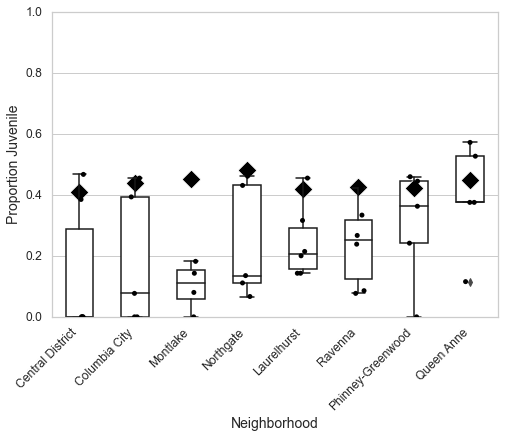

In [13]:
#Make the chart.


#Plots using Seaborn
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 8]})
bplot = sns.boxplot(y='juvpercent', x='neighborhood', data=juv,
                 width=0.5)
#                 palette="colorblind")

#Remove default colors 
plt.setp(bplot.artists, edgecolor = 'k', facecolor='w')
plt.setp(bplot.lines, color='k')

# add stripplot to boxplot with Seaborn
bplot=sns.stripplot(y='juvpercent', x='neighborhood', data=juv, 
                   jitter=True, 
                   marker='o', 
                   alpha=1,
                   color='black')

# SPL juvenile percentages
bplot=sns.scatterplot(y='percent', x='neighborhood', data=juvSPLsorted, marker='D', color='#000000', s=175)


#Set y axis label and scale

bplot.set_ylabel("Proportion Juvenile",
                fontsize=14)
bplot.set_xlabel("Neighborhood",
                fontsize=14)
bplot.set(ylim=(0, 1))



#rotate labels
for item in bplot.get_xticklabels():
    item.set_rotation(45)
    item.set_ha('right') #This sets horizontal alignment

plt.gcf().subplots_adjust(bottom=0.35) #makes room for the 'tall' x axis lables

#Save figure 
plt.savefig('../figures/age.eps', dpi=300, format="eps")
plt.savefig('../figures/age.png', dpi=300, format="png")

In [37]:
juvhood = lflJPercent #use dataframe created above
juvhood['count'] =  juvhood['lfltotal'] - juvhood['adultcount']
juvhood.head()

,neighborhood,adultcount,lfltotal,juvpercent,count
0,Central District,69,93,0.258065,24
1,Columbia City,64,86,0.255814,22
2,Laurelhurst,66,91,0.274725,25
3,Montlake,74,81,0.086420,7
4,Northgate,158,240,0.341667,82


In [38]:
#Set up table for Chi Square to compare age proportion between neighborhoods
juvTotal = juvhood['count'].sum()
totBks = juvhood['lfltotal'].sum()
juvhood['expCount']= (juvTotal*juvhood['lfltotal'])/totBks #only need this if doing chisquare rather than chi2: expected value is row total times col total divided by grand total. Accounts for different number of books
juvhood.head(8)

,neighborhood,adultcount,lfltotal,juvpercent,count,expCount
0,Central District,69,93,0.258065,24,27.082922
1,Columbia City,64,86,0.255814,22,25.044423
2,Laurelhurst,66,91,0.274725,25,26.500494
3,Montlake,74,81,0.086420,7,23.588351
4,Northgate,158,240,0.341667,82,69.891412
5,Phinney-Greenwood,123,191,0.356021,68,55.621915
6,Queen Anne,68,107,0.364486,39,31.159921
7,Ravenna,96,124,0.225806,28,36.110563


In [39]:
juvChi = juvhood[['count','adultcount']]
chi2, p, dof, ex = chi2_contingency(juvChi, correction=False) #using chi2 here rather than chisquare because including adult book rather than specifying distribution (expected values)
print("chi: ",chi2,"p-value: ",p)

chi:  29.795075312815484 p-value:  0.00010353925399179392


In [40]:
# gathering all combinations for post-hoc chi2
#Thanks to: https://neuhofmo.github.io/chi-square-and-post-hoc-in-python/
all_combinations = list(combinations(juvChi.index, 2))
print("Significance results:")
for comb in all_combinations:
    # subset df into a dataframe containing only the pair "comb"
    new_df = juvChi[(juvChi.index == comb[0]) | (juvChi.index == comb[1])]
    # running chi2 test
    chi2, p, dof, ex = chi2_contingency(new_df, correction=False)
    print(f"Chi2 result for pair {comb}: {chi2}, p-value: {p}")

Significance results:
Chi2 result for pair (0, 1): 0.001185242371397054, p-value: 0.9725363749043079
Chi2 result for pair (0, 2): 0.06534341965546722, p-value: 0.798241501426806
Chi2 result for pair (0, 3): 8.711252442782097, p-value: 0.003162518600832293
Chi2 result for pair (0, 4): 2.1589451041797925, p-value: 0.1417419700123612
Chi2 result for pair (0, 5): 2.740384262352863, p-value: 0.09784123679734145
Chi2 result for pair (0, 6): 2.6115243106236217, p-value: 0.1060897436160091
Chi2 result for pair (0, 7): 0.30349650349650326, p-value: 0.5816986849638196
Chi2 result for pair (1, 2): 0.08108035533909987, p-value: 0.7758386506163414
Chi2 result for pair (1, 3): 8.341034765419469, p-value: 0.003875951593633555
Chi2 result for pair (1, 4): 2.1480729611543565, p-value: 0.1427489589658645
Chi2 result for pair (1, 5): 2.714710335244495, p-value: 0.099427017851437
Chi2 result for pair (1, 6): 2.604781590818125, p-value: 0.1065418346431222
Chi2 result for pair (1, 7): 0.25206301575393847, p

While the overall chi square test is significant, even bonferroni corrected, only one of the indiv. tests is (Montlake and Laurelhurst) and that is extremely close. This suggests the significance is an accumulation of small contributions from combinations rather than a large contribution for any one or more combinations.

In [32]:
#Here's the list of neighborhoods corresponding to above. Bonferonni- 0.05/29=0.00172
juvhood

,neighborhood,adultcount,lfltotal,juvpercent,count,expCount
0,Central District,69,93,0.258065,24,26.899309
1,Columbia City,64,86,0.255814,22,24.874630
2,Laurelhurst,67,91,0.263736,24,26.320829
3,Montlake,74,81,0.086420,7,23.428430
4,Northgate,158,240,0.341667,82,69.417572
5,Phinney-Greenwood,123,191,0.356021,68,55.244817
6,Queen Anne,69,107,0.355140,38,30.948667
7,Ravenna,96,124,0.225806,28,35.865745


### Create Figure 2

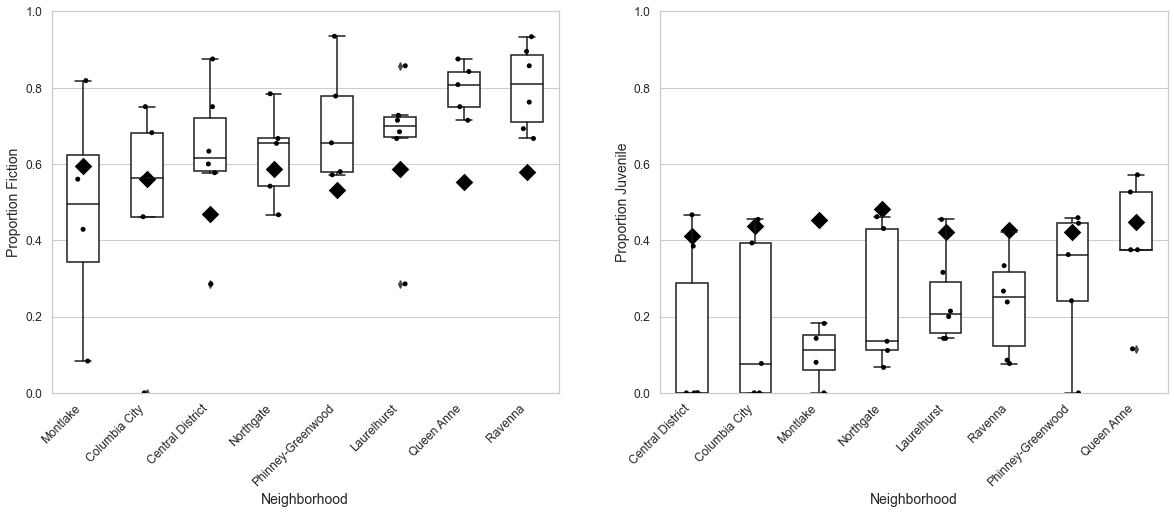

In [55]:
#Not the most efficient way to do this...
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [20, 10]})

def plotfic(df_x,ax):
    f = sns.boxplot(y='percent', x='neighborhood', data=df_x,
                 width=0.5, ax=ax)
#                 palette="colorblind")

    # add stripplot to boxplot with Seaborn
    f = sns.stripplot(y='percent', x='neighborhood', data=df_x, 
                    jitter=True, 
                    marker='o', 
                    alpha=1,
                    color='black',
                    ax=ax)
    # SPL fiction percentages
    f = sns.scatterplot(y='percent', x='neighborhood', data=ficSPLsorted, marker='D', color='#000000', s=175, ax=ax)
    #Remove default colors 
    plt.setp(f.artists, edgecolor = 'k', facecolor='w')
    plt.setp(f.lines, color='k')

#Set y axis label and scale

    f.set_ylabel("Proportion Fiction",
                    fontsize=14)
    f.set_xlabel("Neighborhood",
                    fontsize=14)
    f.set(ylim=(0, 1))

    #rotate labels
    for item in f.get_xticklabels():
        item.set_rotation(45)
        item.set_ha('right') #This sets horizontal alignment

    plt.gcf().subplots_adjust(bottom=0.35) #makes room for the 'tall' x axis lables
    return f
    
def plotjuv(df_x,ax):
    g = sns.boxplot(y='juvpercent', x='neighborhood', data=df_x,
                 width=0.5, ax=ax)
    g = sns.stripplot(y='juvpercent', x='neighborhood', data=df_x, 
                    jitter=True, 
                    marker='o', 
                    alpha=1,
                    color='black',
                    ax=ax)
    g = sns.scatterplot(y='percent', x='neighborhood', data=juvSPLsorted, marker='D', color='#000000', s=175, ax=ax)
    plt.setp(g.artists, edgecolor = 'k', facecolor='w') #Remove default colors
    plt.setp(g.lines, color='k')
    g.set_ylabel("Proportion Juvenile",
                fontsize=14)
    g.set_xlabel("Neighborhood",
                fontsize=14)
    g.set(ylim=(0, 1))
    #rotate labels
    for item in g.get_xticklabels():
        item.set_rotation(45)
        item.set_ha('right') #This sets horizontal alignment
    plt.gcf().subplots_adjust(bottom=0.35) #makes room for the 'tall' x axis lables
    return g



fig, ax = plt.subplots(ncols=2)
plotfic(fic,ax[0])
plotjuv(juv,ax[1])

#Save figure 
plt.savefig('../figures/figure2.eps', dpi=300, format="eps")
plt.savefig('../figures/figure2.png', dpi=300, format="png")

# Transit Analysis

For privacy protection, the data file indicating which LFLs were located near transit lines is not publically available.

Run the above Figure 2 analysis first

In [15]:
#Open file
lfltransit = pd.read_csv('C:/Users/Andre/Documents/Research\Little_free_lib/data/Files that are not in GitHub but still important/transit-lfls.csv',encoding='utf-8')
lfltransit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   collection  42 non-null     object
 1   Transit     42 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 800.0+ bytes


In [56]:
#Merge transit with fiction 
collfiction = bksfiction[bksfiction['type'] == 'Fiction']
colltransit = pd.merge(collfiction, lfltransit, on='collection', how='inner')
colltransit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 0 to 41
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   neighborhood  42 non-null     object 
 1   collection    42 non-null     object 
 2   type          42 non-null     object 
 3   count         42 non-null     int64  
 4   total         42 non-null     int64  
 5   percent       42 non-null     float64
 6   Transit       42 non-null     int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 2.6+ KB


In [61]:
#t-test for Fiction. This is comparing LFLs near transit and not near transit. It does not account for any differences found in 
#percent Fiction between neighborhoods

transit = colltransit['percent'][colltransit['Transit']==True]
residential = colltransit['percent'][colltransit['Transit']==False]

ttest_ind(transit, residential)

Ttest_indResult(statistic=1.4689743123350234, pvalue=0.14966108061380937)

In [65]:
#t-test for reading level (juvenile vs adult). This is comparing LFLs near transit and not near transit. It does not account for any differences found in 
#percent Fiction between neighborhoods

#Merge transit with juvenile datafraom
colljuvtransit = pd.merge(bksjuvenile, lfltransit, on='collection', how='inner')


transit = colljuvtransit['juvpercent'][colljuvtransit['Transit']==True]
residential = colljuvtransit['juvpercent'][colljuvtransit['Transit']==False]

ttest_ind(transit, residential)

Ttest_indResult(statistic=0.8932220968494384, pvalue=0.37708095717439094)

## Examine Author Diversity
The list was first compared to two lists crowdsourced on GoodReads (https://www.goodreads.com/list/show/96119._ReadPOC_List_of_Books_by_Authors_of_Color and https://www.goodreads.com/list/show/96282._ReadPOC_List_of_Romance_Books_by_Authors_of_Color). We also researched every author in an attempt to record if they identify as BIPOC.

In [71]:
# Remove non person authors
bksauthors = bks.loc[bks['nonPersonAuthor']==0].copy()
bksauthors.head()

,yrpub,count,authorOfColor,nonPersonAuthor,neighborhood,collection,type,age,category1,category2,category1Code,languages,originalLang,combinedName
1,2007,1,0,0,Central District,CentralDistrict1,Fiction,Adult,Religion,Null,R,English,English,William P. Young
2,2006,1,0,0,Central District,CentralDistrict1,Fiction,Adult,Suspense,Novel,SUS,English,English,Dick Couch
3,1992,1,0,0,Central District,CentralDistrict1,Fiction,Adult,Suspense,Null,SUS,English,English,James Grady
4,1989,1,0,0,Central District,CentralDistrict2,Fiction,Adult,Anthology/Essays/Short stories,Null,AN,English,NaN,"Hollis Hodges, Loup Durand, Elliott Roosevelt ..."
5,1990,1,0,0,Central District,CentralDistrict2,Fiction,Adult,Anthology/Essays/Short stories,Null,AN,English,NaN,Dick Francis


In [61]:
#Some basic stats
BIPOCbooks=bksauthors['authorOfColor'].sum()
totalbks = bksauthors['count'].sum()
BIPOCPercent = BIPOCbooks/totalbks
print(f'Total books: {totalbks}, total books by authors of color: {BIPOCbooks}, proportion books by authors of color: {BIPOCPercent}')

Total books: 949, total books by authors of color: 74, proportion books by authors of color: 0.0779768177028451


In [78]:
#Unique Authors
uniqueAuthors = bksauthors['combinedName'].unique()
BIPOCauthors = bksauthors.loc[bksauthors['authorOfColor']==1].copy()
uniqueAuthorsBIPOC = BIPOCauthors['combinedName'].unique()
print('Unique authors =',len(uniqueAuthors),'Unique BIPOC authors =',len(uniqueAuthorsBIPOC))

Unique authors = 825 Unique BIPOC authors = 70


In [79]:
#Percent by neighborhood 
#Groups count by neighborhood, collection, calculate percent
bksauthorshood = bksauthors.groupby(['neighborhood', 'authorOfColor'])['count'].sum().reset_index()
bksauthorshood['total'] = bksauthorshood.groupby('neighborhood')['count'].transform('sum')
bksauthorshood['percent'] = bksauthorshood['count']/bksauthorshood['total']

bksauthorshood = bksauthorshood.loc[bksauthorshood['authorOfColor']==1].copy() #adding the .copy() gets rid of the settingwithcopywarning

#Sort and reindex so that the chart goes low to high
bksauthorshood = bksauthorshood.sort_values(by=['percent'], ascending=True).reset_index()

In [80]:
bksauthorshood.head(8)

,index,neighborhood,authorOfColor,count,total,percent
0,11,Phinney-Greenwood,1,9,177,0.050847
1,7,Montlake,1,4,66,0.060606
2,5,Laurelhurst,1,6,91,0.065934
3,3,Columbia City,1,6,84,0.071429
4,15,Ravenna,1,9,124,0.072581
5,1,Central District,1,6,82,0.073171
6,13,Queen Anne,1,9,102,0.088235
7,9,Northgate,1,25,223,0.112108


In [81]:
print('Total ', bksauthorshood['total'].sum(), ' Books with authors of color: ', bksauthorshood['count'].sum())

Total  949  Books with authors of color:  74


In [38]:
#Chi Square. Problem is Central is less than 5 so cannot use.

#from scipy.stats import chisquare
#bksauthorshood['expectedAoc']=bksauthorshood['total']/991*68 #add column of expected number of author of color books
#chisquare(bksauthorshood['count'],f_exp=bksauthorshood['expectedAoc'])


In [46]:
#Percent by LFL and neighborhood

#Groups count by neighborhood, collection, calculate percent
bksauthorsgrp = bksauthors.groupby(['neighborhood','collection', 'authorOfColor'])['count'].sum().reset_index()
bksauthorsgrp['total'] = bksauthorsgrp.groupby('collection')['count'].transform('sum')
bksauthorsgrp['percent'] = bksauthorsgrp['count']/bksauthorsgrp['total']



In [47]:
# I inspected the data and there are no LFLs with 100% authors of color.  To preserve the LFLs with no authors of color
# convert those with 100% white authors to zeros.  Then remove the rows that show percent white authors below 100%
#leaving percent column only percent authors of color

bksauthorsgrp.loc[bksauthorsgrp.percent == 1, 'percent'] = 0
bksaoc = bksauthorsgrp.drop(bksauthorsgrp[(bksauthorsgrp['authorOfColor'] == 0) & (bksauthorsgrp['percent'] > 0)].index)
bksaoc.head()

,neighborhood,collection,authorOfColor,count,total,percent
0,Central District,CentralDistrict1,0,3,3,0.000000
2,Central District,CentralDistrict2,1,2,15,0.133333
3,Central District,CentralDistrict3,0,28,28,0.000000
5,Central District,CentralDistrict4,1,1,22,0.045455
7,Central District,CentralDistrict5,1,2,6,0.333333


In [48]:
#Sort and reindex so that the chart will go low to high
bksaoc['median'] = bksaoc.groupby('neighborhood')['percent'].transform('median')
bksaoc = bksaoc.sort_values(by=['median'], ascending=True).reset_index()
bksaoc.head()

,index,neighborhood,collection,authorOfColor,count,total,percent,median
0,33,Montlake,Montlake6,0,11,11,0.000000,0.020833
1,32,Montlake,Montlake5,1,3,16,0.187500,0.020833
2,30,Montlake,Montlake4,1,1,24,0.041667,0.020833
3,28,Montlake,Montlake2,0,15,15,0.000000,0.020833
4,43,Phinney-Greenwood,Phinney-Green1,0,14,14,0.000000,0.032787


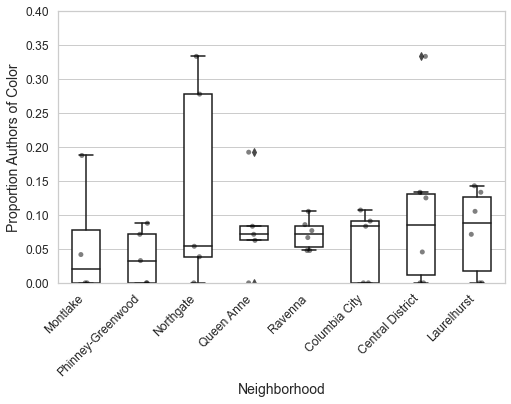

In [49]:
#Plots using Seaborn
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})

bplot = sns.boxplot(y='percent', x='neighborhood', data=bksaoc,
                 width=0.5)
#                 palette="colorblind")

#Remove default colors 
plt.setp(bplot.artists, edgecolor = 'k', facecolor='w')
plt.setp(bplot.lines, color='k')

# add stripplot to boxplot with Seaborn
bplot=sns.stripplot(y='percent', x='neighborhood', data=bksaoc, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black')

#Set y axis label and scale

bplot.set_ylabel("Proportion Authors of Color",
                fontsize=14)
bplot.set_xlabel("Neighborhood",
                fontsize=14)
bplot.set(ylim=(0, 0.4))



#rotate labels
for item in bplot.get_xticklabels():
    item.set_rotation(45)
    item.set_ha('right') #This sets horizontal alignment

### Add in socioeconomic data from census data notebook
The section this produces is a scatterplot of percent authors of color versus gini-simpson index.

In [50]:
dfsocioecon = pd.read_csv('../census/socioeconomic-by-neighborhood.csv', encoding='utf-8')

In [51]:
#Merge with the lfl number dataset
dfAocSocio = pd.merge(bksauthorshood, dfsocioecon, on='neighborhood', how='inner')
dfAocSocio.head()

,index,neighborhood,authorOfColor,count,total,percent,avg-median-income,pop,numlfls,tot,...,afam,amin,as,hw,ot,combo1,combo2,combo3,simpsons,gini-simp
0,11,Phinney-Greenwood,1,9,177,0.050847,96876.333333,23948,20,25401,...,424,85,1668,14,310,1469,94,1375,0.722881,0.277119
1,7,Montlake,1,4,66,0.060606,144488.500000,8644,8,9546,...,109,36,763,38,91,461,60,401,0.721553,0.278447
2,5,Laurelhurst,1,6,91,0.065934,127971.500000,10479,11,11010,...,303,0,1289,13,45,478,0,478,0.669051,0.330949
3,3,Columbia City,1,6,84,0.071429,67992.000000,16883,9,18983,...,5152,159,4960,86,169,1458,0,1458,0.289836,0.710164
4,15,Ravenna,1,9,124,0.072581,101129.833333,24187,24,25957,...,376,58,3135,98,298,1405,85,1320,0.649513,0.350487


In [52]:
#Get rid of extraneous columns
dfAocSocio = dfAocSocio.drop(columns=['tot','wh','afam','amin','as','hw','ot','combo1','combo2','combo3'])

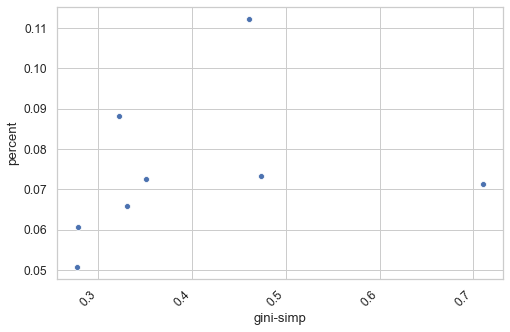

In [53]:
#Plots using Seaborn
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})

bplot = sns.scatterplot(y='percent', x='gini-simp', data=dfAocSocio)
#                 palette="colorblind")

#Remove default colors 
plt.setp(bplot.artists, edgecolor = 'k', facecolor='w')
plt.setp(bplot.lines, color='k')


#rotate labels
for item in bplot.get_xticklabels():
    item.set_rotation(45)
    item.set_ha('right') #This sets horizontal alignment

## Spearmans for BIPOC authors and neighborhood diversity

In [55]:
#Use SciPy

import scipy
from scipy import stats

#The %.3f' sets the number of decimal places
coef, p = stats.spearmanr(dfAocSocio['gini-simp'],dfAocSocio['percent'])
print('Spearmans correlation coefficient: %.3f' % coef,' p-value: %.3f' % p)

Spearmans correlation coefficient: 0.548  p-value: 0.160


In [56]:
#The %.3f' sets the number of decimal places
coef, p = stats.spearmanr(dfAocSocio['avg-median-income'],dfAocSocio['percent'])
print('Spearmans correlation coefficient: %.3f' % coef,' p-value: %.3f' % p)

Spearmans correlation coefficient: -0.262  p-value: 0.531


## Create dataset with LFL volumes and owner intentions.
Ultimate Dataframe = bksctstat
Set up a seperate csv with lfl volume and house price. Make sure all numerical columns are number format. Year is okay as int

In [57]:
#Only do this if you are running from the beginning
dfstats = pd.read_csv('lfl-stats.csv')

In [166]:
dfstats['vol'] = (dfstats['width']*dfstats['length']*dfstats['height']/1728) #add a vol column with cubic feet units
dfstats = dfstats[np.isfinite(dfstats['vol'])] #Keep rows that have vol
dfstats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 0 to 41
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   collection  42 non-null     object 
 1   width       42 non-null     float64
 2   length      42 non-null     float64
 3   height      42 non-null     int64  
 4   volMeters   42 non-null     float64
 5   adjPrice    38 non-null     float64
 6   specific    42 non-null     object 
 7   current     42 non-null     object 
 8   variety     42 non-null     object 
 9   kids        42 non-null     object 
 10  religion    42 non-null     object 
 11  porn        42 non-null     object 
 12  vol         42 non-null     float64
dtypes: float64(5), int64(1), object(7)
memory usage: 4.6+ KB


In [167]:
#Groups count by collection
bksct = bks.groupby(['neighborhood','collection'])['count'].sum().reset_index()
bksct.head()

,neighborhood,collection,count
0,Central District,CentralDistrict1,4
1,Central District,CentralDistrict2,16
2,Central District,CentralDistrict3,30
3,Central District,CentralDistrict4,26
4,Central District,CentralDistrict5,7


### Books per Volume

In [168]:
#Create a new dataframe of book counts and lfl stats. Inner join is intersection so removes rows with no partner in other dataframe
bksctstat = pd.merge(dfstats, bksct, on='collection', how='inner')

In [169]:
bksctstat.head()
# The vol column is cubic feet

,collection,width,length,height,volMeters,adjPrice,specific,current,variety,kids,religion,porn,vol,neighborhood,count
0,CentralDistrict1,0.0,0.0,0,0.000000,0.0000,n,n,n,n,n,n,0.000000,Central District,4
1,CentralDistrict2,22.0,11.0,12,0.047588,536554.0424,n,n,n,n,n,n,1.680556,Central District,16
2,CentralDistrict3,23.0,11.0,14,0.058043,124155.9225,n,n,n,n,n,n,2.049769,Central District,30
3,CentralDistrict4,16.0,13.5,21,0.074332,437730.5987,n,y,n,n,y,n,2.625000,Central District,26
4,CentralDistrict5,13.0,14.5,12,0.037067,827225.2702,n,n,y,y,n,n,1.309028,Central District,7


In [62]:
bksctstat['bkPerVol'] = bksctstat['count']/bksctstat['vol']
bksctstat.head(5)

,collection,width,length,height,volMeters,adjPrice,specific,current,variety,kids,religion,porn,vol,neighborhood,count,bkPerVol
0,CentralDistrict1,0.0,0.0,0,0.000000,0.0000,n,n,n,n,n,n,0.000000,Central District,4,inf
1,CentralDistrict2,22.0,11.0,12,0.047588,536554.0424,n,n,n,n,n,n,1.680556,Central District,16,9.520661
2,CentralDistrict3,23.0,11.0,14,0.058043,124155.9225,n,n,n,n,n,n,2.049769,Central District,30,14.635799
3,CentralDistrict4,16.0,13.5,21,0.074332,437730.5987,n,n,n,n,y,n,2.625000,Central District,26,9.904762
4,CentralDistrict5,13.0,14.5,12,0.037067,827225.2702,n,n,y,y,n,n,1.309028,Central District,7,5.347480


In [63]:
bksctstat.head(6)

,collection,width,length,height,volMeters,adjPrice,specific,current,variety,kids,religion,porn,vol,neighborhood,count,bkPerVol
0,CentralDistrict1,0.0,0.0,0,0.000000,0.0000,n,n,n,n,n,n,0.000000,Central District,4,inf
1,CentralDistrict2,22.0,11.0,12,0.047588,536554.0424,n,n,n,n,n,n,1.680556,Central District,16,9.520661
2,CentralDistrict3,23.0,11.0,14,0.058043,124155.9225,n,n,n,n,n,n,2.049769,Central District,30,14.635799
3,CentralDistrict4,16.0,13.5,21,0.074332,437730.5987,n,n,n,n,y,n,2.625000,Central District,26,9.904762
4,CentralDistrict5,13.0,14.5,12,0.037067,827225.2702,n,n,y,y,n,n,1.309028,Central District,7,5.347480
5,CentralDistrict6,16.5,9.0,20,0.048670,479452.9534,n,y,n,n,n,n,1.718750,Central District,10,5.818182


In [64]:
totalbooks=bksctstat['count'].sum()
totalvol = bksctstat['vol'].sum()
bkdensity = totalbooks/totalvol
print(bkdensity)

7.412434450426342


In [65]:
#There is one LFL with no volume so it's density is 'inf'. Set that to null
bksctstat = bksctstat.replace(np.inf, np.nan)

In [66]:
#Look at range
print("Range books per cubic foot",bksctstat['bkPerVol'].min()," - ",bksctstat['bkPerVol'].max())

Range books per cubic foot 3.1973684210526314  -  22.2


In [67]:
bksctstat['medianVol'] = bksctstat.groupby('neighborhood')['bkPerVol'].transform('median')
mediansVol = bksctstat[['neighborhood','medianVol']].copy()
mediansVol.drop_duplicates(inplace=True)
mediansVol

,neighborhood,medianVol
0,Central District,9.520661
6,Columbia City,7.233909
11,Laurelhurst,7.132591
17,Montlake,11.760000
21,Northgate,10.633846
26,Phinney-Greenwood,9.376534
31,Queen Anne,9.047966
36,Ravenna,9.926579


[Text(0, 0.5, 'Books per Cubic Foot'),
 Text(0.5, 0, 'Seattle Little Free Libraries')]

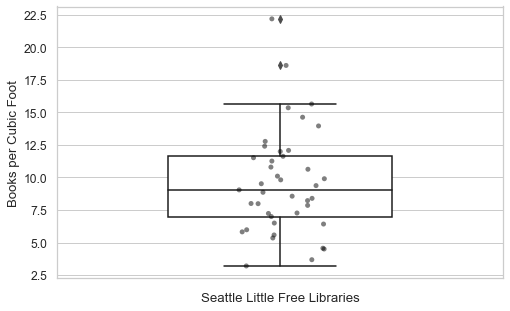

In [68]:
#Plots using Seaborn
bksctstatplot = sns.boxplot(y='bkPerVol', data=bksctstat,
                 width=0.5)
#                palette="colorblind")

#Remove default colors 
plt.setp(bksctstatplot.artists, edgecolor = 'k', facecolor='w')
plt.setp(bksctstatplot.lines, color='k')

# add stripplot to boxplot with Seaborn
bksctstatplot =sns.stripplot(y='bkPerVol', data=bksctstat, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black')

bksctstatplot.set(xlabel='Seattle Little Free Libraries', ylabel='Books per Cubic Foot')

In [69]:
#Set up the dataframe to plot median book per volume by neighborhood

#Groups count by Neighborhood, calculate median
bksctstat['median'] = bksctstat.groupby('neighborhood')['bkPerVol'].transform('median')
bksctstat = bksctstat.sort_values(by=['median'], ascending=True).reset_index()
bksctstat.head(1)

,index,collection,width,length,height,volMeters,adjPrice,specific,current,variety,kids,religion,porn,vol,neighborhood,count,bkPerVol,medianVol,median
0,15,Laurelhurst5,15.0,15.0,15,0.055306,722576.8014,n,n,n,n,n,y,1.953125,Laurelhurst,22,11.264,7.132591,7.132591


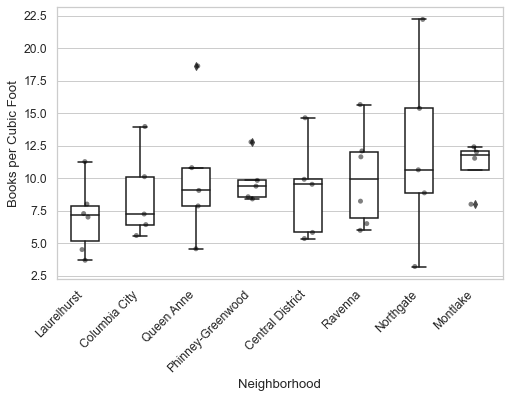

In [70]:
#Plots using Seaborn


bksctstatplot = sns.boxplot(y='bkPerVol', x='neighborhood', data=bksctstat,
                 width=0.5)
#                 palette="colorblind")

#Remove default colors 
plt.setp(bksctstatplot.artists, edgecolor = 'k', facecolor='w')
plt.setp(bksctstatplot.lines, color='k')

# add stripplot to boxplot with Seaborn
bksctstatplot=sns.stripplot(y='bkPerVol', x='neighborhood', data=bksctstat, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black')

bksctstatplot.set(xlabel='Neighborhood', ylabel='Books per Cubic Foot')

#rotate labels
for item in bksctstatplot.get_xticklabels():
    item.set_rotation(45)
    item.set_ha('right')

In [65]:
#Save the file if you need it
bksctstat.to_csv('bkstats.csv', mode = 'w', index=False)

# Checking Preference

## Checking People's Desires vs the Content - Children

In [144]:
#Create a new dataframe of Children's books and lfl stats. Inner join is intersection so removes rows with no partner in other dataframe
bkscategory = bks.groupby(['neighborhood', 'collection','category2'])['count'].sum().reset_index()
#Merge with the stats dataframe to get owner preference column
bksstatchil = pd.merge(bksctstat, bkscategory, on='collection', how='inner')
bksstatchil.rename(columns = {'count_x':'total_count'}, inplace = True)
bksstatchil.rename(columns = {'count_y':'chil_count'}, inplace = True)
bksstatchil.rename(columns = {'neighborhood_y':'neighborhood'}, inplace = True)
#bksstatrel=bksstatchil.drop('neighborhood_x',1)
bksstatchil.head()

,index,collection,width,length,height,volMeters,adjPrice,specific,current,variety,...,porn,vol,neighborhood_x,total_count,bkPerVol,medianVol,median,neighborhood,category2,chil_count
0,15,Laurelhurst5,15.0,15.0,15,0.055306,722576.8014,n,n,n,...,y,1.953125,Laurelhurst,22,11.264,7.132591,7.132591,Laurelhurst,Anthology/Essays/Short stories,1
1,15,Laurelhurst5,15.0,15.0,15,0.055306,722576.8014,n,n,n,...,y,1.953125,Laurelhurst,22,11.264,7.132591,7.132591,Laurelhurst,Biography/Autobiography/Memoir,1
2,15,Laurelhurst5,15.0,15.0,15,0.055306,722576.8014,n,n,n,...,y,1.953125,Laurelhurst,22,11.264,7.132591,7.132591,Laurelhurst,Domestic Fiction,3
3,15,Laurelhurst5,15.0,15.0,15,0.055306,722576.8014,n,n,n,...,y,1.953125,Laurelhurst,22,11.264,7.132591,7.132591,Laurelhurst,Historical Fiction,1
4,15,Laurelhurst5,15.0,15.0,15,0.055306,722576.8014,n,n,n,...,y,1.953125,Laurelhurst,22,11.264,7.132591,7.132591,Laurelhurst,History,1


In [155]:
#Create two dataframes containg data for those who want children's books and those who did not say
#Those who say they want children books
yesWant = bksstatchil[bksstatchil['kids']=='y']
thoseWhoWant = yesWant['chil_count'][yesWant['category2']=='Null'].sum()
thoseWhoWanttotal = yesWant['chil_count'].sum()

#Those who did not mention it
didntMention = bksstatchil[bksstatchil['kids']=='n']
thoseDidntMention = didntMention['chil_count'][didntMention['category2']=='Null'].sum()
thoseDidntMentiontotal = didntMention['chil_count'].sum()

#Calculate the percent religious material in total collection for each group.
print('For those who want childrens books they had',thoseWhoWant/thoseWhoWanttotal, 'And others',thoseDidntMention/thoseDidntMentiontotal)

For those who want childrens books they had 0.21008403361344538 And others 0.24384787472035793


In [157]:
#t-test

from scipy.stats import ttest_ind

cat1 = yesWant['chil_count'][yesWant['category2']=='Null']
cat2 = didntMention['chil_count'][didntMention['category2']=='Null']

ttest_ind(cat1, cat2)

Ttest_indResult(statistic=-0.6023166110166347, pvalue=0.5516443176422268)

In [85]:
#For overall percent of children's books
#Get percents for each category
#Group by category
bksagepercent = bks.groupby(['age'])['count'].sum().reset_index()
#Get total
bkscatTotal = bks['count'].sum()
#create a percent column
bksagepercent['percent'] = bksagepercent['count']/bkscatTotal
#Sort by the percent
bksagepercent.sort_values(by='percent', ascending=False, inplace=True)
bksagepercent.head(15)

,age,count,percent
0,Adult,718,0.708786
1,Childrens,249,0.245805
2,Young Adult,46,0.045410


## Checking People's Desires vs the Content - Religion

****Note: For this analysis, religious children's books are included (indicated in category2)***

This is tough because most who say they don't want religious texts, don't have any so there are a lot of zeros.  Those get dropped in the inner join.
Best thing to do would be just report religion as exists or not.

In [117]:
#Create a new dataframe of religion books and lfl stats. Inner join is intersection so removes rows with no partner in other dataframe
bkscategory = bks.groupby(['neighborhood', 'collection','category2'])['count'].sum().reset_index()
#Merge with the stats dataframe to get owner preference column
bksstatrel = pd.merge(bksctstat, bkscategory, on='collection', how='inner')
bksstatrel.rename(columns = {'count_x':'total_count'}, inplace = True)
bksstatrel.rename(columns = {'count_y':'rel_count'}, inplace = True)
bksstatrel.rename(columns = {'neighborhood_y':'neighborhood'}, inplace = True)
#bksstatrel=bksstatchil.drop('neighborhood_x',1)
bksstatrel.head()

,index,collection,width,length,height,volMeters,adjPrice,specific,current,variety,...,porn,vol,neighborhood_x,total_count,bkPerVol,medianVol,median,neighborhood,category2,rel_count
0,15,Laurelhurst5,15.0,15.0,15,0.055306,722576.8014,n,n,n,...,y,1.953125,Laurelhurst,22,11.264,7.132591,7.132591,Laurelhurst,Anthology/Essays/Short stories,1
1,15,Laurelhurst5,15.0,15.0,15,0.055306,722576.8014,n,n,n,...,y,1.953125,Laurelhurst,22,11.264,7.132591,7.132591,Laurelhurst,Biography/Autobiography/Memoir,1
2,15,Laurelhurst5,15.0,15.0,15,0.055306,722576.8014,n,n,n,...,y,1.953125,Laurelhurst,22,11.264,7.132591,7.132591,Laurelhurst,Domestic Fiction,3
3,15,Laurelhurst5,15.0,15.0,15,0.055306,722576.8014,n,n,n,...,y,1.953125,Laurelhurst,22,11.264,7.132591,7.132591,Laurelhurst,Historical Fiction,1
4,15,Laurelhurst5,15.0,15.0,15,0.055306,722576.8014,n,n,n,...,y,1.953125,Laurelhurst,22,11.264,7.132591,7.132591,Laurelhurst,History,1


In [125]:
#Create two dataframes containg data for those who do remove religious and those who did not say
#Those who say they remove religious material
yesRemove = bksstatrel[bksstatrel['religion']=='y']
thoseWhoRemove = yesRemove['rel_count'][yesRemove['category2']=='Religion'].sum()
thoseWhoRemovetotal = yesRemove['rel_count'].sum()

#Those who did not mention it
noRemove = bksstatrel[bksstatrel['religion']=='n']
thoseWhoDont = noRemove['rel_count'][noRemove['category2']=='Religion'].sum()
thoseWhoDonttotal = noRemove['rel_count'].sum()

#Calculate the percent religious material in total collection for each group.
print('For those who remove religious material they had',thoseWhoRemove/thoseWhoRemovetotal, 'And others',thoseWhoDont/thoseWhoDonttotal)

For those who remove religious material they had 0.03308823529411765 And others 0.029689608636977057


In [133]:
#t-test comparing number of religious books in an LFL based on if the owner said they remove or not

from scipy.stats import ttest_ind

cat1 = yesRemove['rel_count'][yesRemove['category2']=='Religion']
cat2 = noRemove['rel_count'][noRemove['category2']=='Religion']

ttest_ind(cat1, cat2)

Ttest_indResult(statistic=1.3349953256759628, pvalue=0.19948149900258996)

In [134]:
#Total percentage of Religious books
relBkCount = bks['count'][bks['category2']=='Religion'].sum()
print('Proportion of religious books',relBkCount/len(bks))

Proportion of religious books 0.03060217176702863


# Bray Curtis Dissimilarity for Cluster Analysis - part of Figure 4
### Prepare dataframe for Bray Curtis dissimilarity
This sets up a dataframe that is formatted for a more efficient analysis in R. Could not figure out how to do cluster analysis with Python.

In [136]:
#Get percents of category1 by LFL. This is to compare what stewards say to what is in their library
bkscatlflct = bks

#Replace 'Null' with 'Childrens'
bkscatlflct['category1'] = np.where(bkscatlflct['age'] =='Childrens', 'Childrens', bkscatlflct['category1'])

bkscatlflct = bkscatlflct.groupby(['neighborhood','collection', 'category1'])['count'].sum().reset_index()

bkscatlflct = bkscatlflct.rename(columns={'collection': 'lflname'}) #changing name because this is also an index?



In [137]:
#Change the collection column to lflname in the dataframe with volume
bksctstatbc = bksctstat.rename(columns={'collection': 'lflname'})
bksctstatbc = bksctstatbc[['lflname','volMeters']]

#Merge the dataframes
bkscatlflctvol = pd.merge(bkscatlflct, bksctstatbc, on='lflname', how='inner')

#Remove the LFLs with no volume measurement
bkscatlflctvol = bkscatlflctvol[bkscatlflctvol['volMeters'] > 0]

#Calculate book per vol
bkscatlflctvol['density'] = bkscatlflctvol['count']/bkscatlflctvol['volMeters']

In [138]:
#Create dataframe to add in neighborhood column later
hoodscol = bks[['neighborhood', 'collection']].reset_index() #messy but works
hoodscol = hoodscol.rename(columns={'collection': 'lflname'})
hoodscol = hoodscol.drop(columns=['index'])
hoodscol = hoodscol.drop_duplicates()

In [139]:
#Set up the final file

#Unstack the opposite way for use in R
bkscatlflctvolwide = bkscatlflctvol[['lflname','category1','density']]
bkscatlflctvolwide = bkscatlflctvolwide.pivot(index='lflname',columns="category1", values='density')
bkscatlflctvolwide = bkscatlflctvolwide.fillna(0)

#merge to get the neighborhoods as a column
bkscatlflctvolwide = pd.merge(hoodscol, bkscatlflctvolwide, on='lflname', how='inner')

In [140]:
bkscatlflctvolwide.head()

,neighborhood,lflname,Adventure,Anthology/Essays/Short stories,Art,Biography/Autobiography/Memoir,Business/Technology,Childrens,Classics,Comedy,...,Religion,Romance,SCiFi/Fantasy,SciFi/Fantasy,Science,Self Help/Health,Sports,Suspense,Travel,Western
0,Central District,CentralDistrict2,0.000000,63.041103,0.000000,0.000000,21.013701,0.000000,0.0,0.0,...,0.000000,105.068505,0.0,0.000000,0.0,21.013701,0.000000,63.041103,0.0,0.000000
1,Central District,CentralDistrict3,17.228606,0.000000,0.000000,51.685819,0.000000,223.971883,0.0,0.0,...,17.228606,0.000000,0.0,0.000000,0.0,0.000000,0.000000,51.685819,0.0,17.228606
2,Central District,CentralDistrict4,0.000000,13.453156,0.000000,13.453156,13.453156,107.625249,0.0,0.0,...,13.453156,26.906312,0.0,40.359468,0.0,26.906312,13.453156,40.359468,0.0,0.000000
3,Central District,CentralDistrict5,0.000000,26.978175,0.000000,53.956349,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,26.978175,0.000000,0.000000,0.0,0.000000
4,Central District,CentralDistrict6,0.000000,0.000000,20.546538,20.546538,0.000000,0.000000,0.0,0.0,...,20.546538,20.546538,0.0,0.000000,0.0,20.546538,0.000000,20.546538,0.0,0.000000


In [141]:
#Save csv file for use in R
bkscatlflctvolwide.to_csv('cluster/cat-density-collection.csv', mode = 'w', index=False)

## Categories by Neighborhood

***Note that the Religion count and percent here does not include the religious children's books***

In [142]:
#Look at general categories
bkscatgen = bks

#Replace 'Null' with 'Childrens'
bkscatgen['category1'] = np.where(bkscatgen['age'] =='Childrens', 'Childrens', bkscatgen['category1'])

#Group by category
bkscatgen = bks.groupby(['category1'])['count'].sum().reset_index()

#Get total
bkscatTotal = bkscatgen['count'].sum()
#create a percent column
bkscatgen['percent'] = bkscatgen['count']/bkscatTotal
#Sort by the percent
bkscatgen.sort_values(by='percent', ascending=False, inplace=True)
bkscatgen.head(15)


,category1,count,percent
5,Childrens,249,0.245805
17,Mystery,100,0.098717
29,Suspense,79,0.077986
27,Self Help/Health,68,0.067127
25,SciFi/Fantasy,65,0.064166
3,Biography/Autobiography/Memoir,45,0.044423
23,Romance,45,0.044423
10,Domestic Fiction,39,0.038500
13,Historical Fiction,37,0.036525
8,Cookery,36,0.035538


In [143]:
#Sum the percent for top five categories
top5cats = bkscatgen['percent'][0:5].sum()
top5cats

0.5538005923000987

## Chart top 5 categories by neighborhood
Pie charts use counts so need to standardize by LFL volume

In [ ]:
#Create a datframe of total volume for each collection
dfstats['vol'] = (dfstats['width']*dfstats['length']*dfstats['height']/1728) #add a vol column with cubic feet units
dfstats = dfstats[dfstats['vol']>0] #Keep rows that have vol
dfstats = dfstats[['collection','vol']]
dfstats.info()

In [ ]:
#Add transit vs residential information into the bks dataframe and then add vol info. This does not keep any books that are
#in an LFL we do not have volume for
bkstransit = pd.merge(bks, lfltransit, on='collection', how='inner')
bksvoltransit = pd.merge(bkstransit, dfstats, on='collection', how='inner')
bksvoltransit.info()

In [3]:
#Get percents of category1 by neighborhood
bkscat = bks.groupby(['neighborhood', 'category1Code'])['count'].sum().reset_index()
#Replace 'Null' with 'Childrens'
bkscat.loc[bkscat.category1Code == 'NU', 'category1Code'] = 'CH'
bkscat.loc[bkscat.category1Code == 'MYS', 'category1Code'] = 'M'
#Create a total column grouped by neighborhood
bkscat['total'] = bkscat.groupby('neighborhood')['count'].transform('sum')
#create a percent column
bkscat['percent'] = bkscat['count']/bkscat['total']
#Sort by the percent
bkscat = bkscat.groupby('neighborhood').apply(pd.DataFrame.sort_values, 'percent', ascending=False)
#Neighborhood column at this point is both the grouping column and a data column, so delete the data one.
#bkscat = bkscat.drop('neighborhood', 1)
bkscat = bkscat.rename(columns={'neighborhood': 'hoodname'})
#Create a cumulative count column by neighborhood
bkscat['cumulct'] = bkscat.groupby(['neighborhood']).cumcount()+1
#Create a new column with the categories not in top 5 categories or over in cumulper marked as 'other'
bkscat['newcat'] = np.where(bkscat['cumulct'] < 6, bkscat['category1Code'], 'Other')
bkscat.head(20)

hoodname category1Code  count  total   percent  \
neighborhood                                                                  
Central District 11  Central District            CH     21     91  0.230769   
                 18  Central District           SUS     12     91  0.131868   
                 14  Central District           ROM      8     91  0.087912   
                 10  Central District             M      7     91  0.076923   
                 3   Central District           BIO      7     91  0.076923   
                 17  Central District            SH      5     91  0.054945   
                 1   Central District            AN      5     91  0.054945   
                 7   Central District             H      4     91  0.043956   
                 13  Central District             R      4     91  0.043956   
                 16  Central District        SCIFAN      3     91  0.032967   
                 12  Central District           POL      3     91  0.032967   
                 4   Central District            BU      2     91  0.021978   
                 8   Central District            HF      2     91  0.021978   
                 9   Central District          LITF      2     91  0.021978   
                 15  Central District             S      1     91  0.010989   
                 0   Central District           ADV      1     91  0.010989   
                 6   Central District            DF      1     91  0.010989   
                 5   Central District            CR      1     91  0.010989   
                 2   Central District           ART      1     91  0.010989   
                 19  Central District            WS      1     91  0.010989   

                     cumulct newcat  
neighborhood                         
Central District 11        1     CH  
                 18        2    SUS  
                 14        3    ROM  
                 10        4      M  
                 3         5    BIO  
                 17        6  Other  
                 1         7  Other  
                 7         8  Other  
                 13        9  Other  
                 16       10  Other  
                 12       11  Other  
                 4        12  Other  
                 8        13  Other  
                 9        14  Other  
                 15       15  Other  
                 0        16  Other  
                 6        17  Other  
                 5        18  Other  
                 2        19  Other  
                 19       20  Other

In [4]:
#Sum the counts by newcat to get all the 'others' together. Pie charts will use counts
bkscatsumall = bkscat.groupby(['neighborhood','newcat'])['count'].sum().reset_index()
bkscatsumall.head(10)

,neighborhood,newcat,count
0,Central District,BIO,7
1,Central District,CH,21
2,Central District,M,7
3,Central District,Other,36
4,Central District,ROM,8
5,Central District,SUS,12
6,Columbia City,BIO,6
7,Columbia City,CH,15
8,Columbia City,Other,46
9,Columbia City,SCIFAN,6


### Plot the Categories

In [191]:
catnames = bkscatsumall['newcat'].unique() #Create list of neighborhood names 
#These set up the color scheme for the pie charts
cmap = plt.cm.gist_earth #tab20b (0.1, 0.9)
colors = cmap(np.linspace(0.1, 0.85, len(catnames)))   #0.85 because Ravenna has white slice otherwise
labels = catnames

In [6]:
#Create a list of the neighborhoods
hoods = pd.DataFrame(dict(neighborhood=bkscatsumall.neighborhood.unique()))
hoods = hoods.sort_values(by=['neighborhood'])
hoods.head()

,neighborhood
0,Central District
1,Columbia City
2,Laurelhurst
3,Montlake
4,Northgate


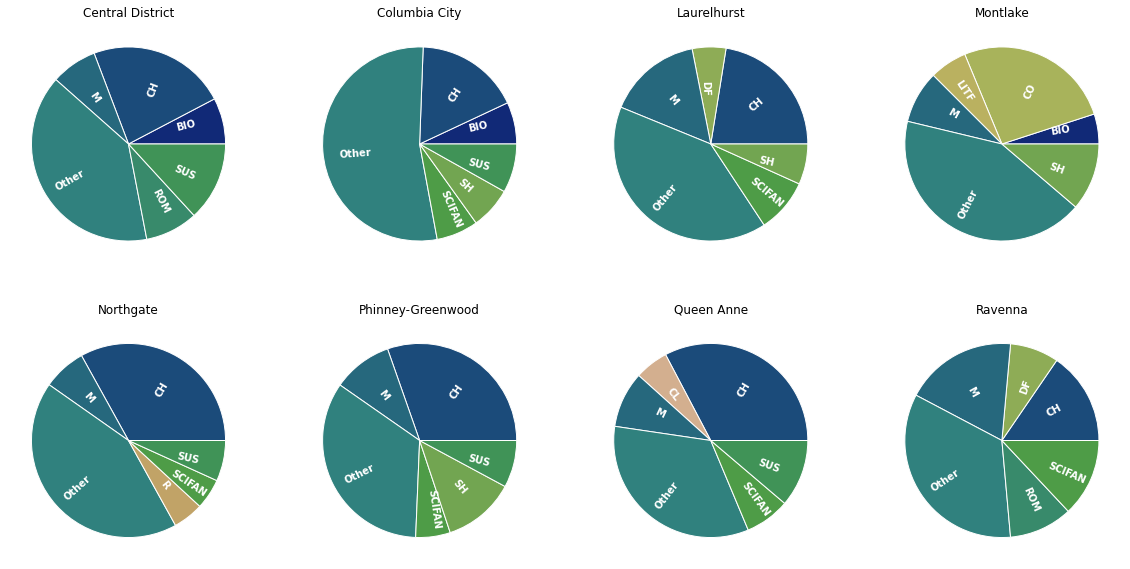

In [7]:
#fig = plt.figure(figsize=(10,10), dpi=300)

fig, axs = plt.subplots(2, 4, figsize=(20,10)) #tight_layout = True)
#fig.subplots_adjust(hspace=0.7, wspace=0.4)

row = [0,0,0,0,1,1,1,1] #row, col, and counter help locate each chart in the overall figure.
col = [0,1,2,3,0,1,2,3]
counter = 0
for hood in hoods['neighborhood']: #For each neighborhood

    rownum = row[counter]
    colnum = col[counter]
    def mypie(slices,labels,colors):

        colordict={}
        for l,c in zip(labels,colors):
            #print(l,c)
            colordict[l]=c
        #fig = plt.figure()
        #ax = fig.add_subplot(111)

        pie_wedge_collection = axs[rownum,colnum].pie(slices, labels=bkscatsumall[bkscatsumall['neighborhood']==hood]['newcat'], labeldistance=0.5, rotatelabels=True, textprops={'color':"w",'weight':"bold"})#, autopct=make_autopct(slices))

        for pie_wedge in pie_wedge_collection[0]:
            pie_wedge.set_edgecolor('white')
            pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])

        titlestring = hood

        axs[rownum,colnum].set_title(titlestring)
    
        return axs[rownum,colnum],pie_wedge_collection

    slices = bkscatsumall[bkscatsumall['neighborhood']==hood]['count']
    axs[rownum,colnum], pie_wedge_collection = mypie(slices,labels,colors)
    #axs[rownum,colnum] = fig
    counter+=1

#Save figure 
plt.savefig('../figures/piecharts.eps', dpi=300, format="eps")
plt.savefig('../figures/piecharts.png', dpi=300, format="png")
#plt.show() #show all figures

# Compare genre between transit and residential

In [68]:
#Open file
lfltransit = pd.read_csv('C:/Users/Andre/Documents/Research\Little_free_lib/data/Files that are not in GitHub but still important/transit-lfls.csv',encoding='utf-8')
lfltransit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   collection  42 non-null     object
 1   Transit     42 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 800.0+ bytes


In [172]:
#Create a datframe of total volume for each 
dfstats['vol'] = (dfstats['width']*dfstats['length']*dfstats['height']/1728) #add a vol column with cubic feet units
dfstats = dfstats[dfstats['vol']>0] #Keep rows that have vol
dfstats = dfstats[['collection','vol']]
dfstats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 1 to 41
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   collection  41 non-null     object 
 1   vol         41 non-null     float64
dtypes: float64(1), object(1)
memory usage: 984.0+ bytes


In [183]:
#Add transit vs residential information into the bks dataframe and then add vol info. This does not keep any books that are
#in an LFL we do not have volume for
bkstransit = pd.merge(bks, lfltransit, on='collection', how='inner')
bksvoltransit = pd.merge(bkstransit, dfstats, on='collection', how='inner')
#Calculate book per volume (this is basically 1 divided by the collection's vol for every book)
bksvoltransit['bkPerVol'] = bksvoltransit['count']/bksvoltransit['vol']
bksvoltransit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 964 entries, 0 to 963
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   yrpub            964 non-null    int64  
 1   count            964 non-null    int64  
 2   authorOfColor    964 non-null    int64  
 3   nonPersonAuthor  964 non-null    int64  
 4   neighborhood     964 non-null    object 
 5   collection       964 non-null    object 
 6   type             964 non-null    object 
 7   age              964 non-null    object 
 8   category1        964 non-null    object 
 9   category2        964 non-null    object 
 10  category1Code    954 non-null    object 
 11  languages        926 non-null    object 
 12  originalLang     884 non-null    object 
 13  combinedName     942 non-null    object 
 14  Transit          964 non-null    int64  
 15  vol              964 non-null    float64
 16  bkPerVol         964 non-null    float64
dtypes: float64(2), i

In [184]:
#Get book per volume for each category by proximity to transit
bkscat = bksvoltransit.groupby(['Transit','category1Code'])['bkPerVol'].sum().reset_index()
#Replace 'Null' with 'Childrens' codes
bkscat.loc[bkscat.category1Code == 'NU', 'category1Code'] = 'CH'
bkscat.loc[bkscat.category1Code == 'MYS', 'category1Code'] = 'M'
#Make the location clear
bkscat['location'] = np.nan
bkscat.loc[bkscat.Transit == True, 'location'] = 'Near Transit'
bkscat.loc[bkscat.Transit == False, 'location'] = 'Not Near Transit'
#Create a total column grouped by collection
#bkscat['total'] = bkscat.groupby('Transit')['bkVol'].transform('sum')
#create a percent column
#bkscat['percent'] = bkscat['count']/bkscat['total']
#Sort by the books per vol
#bkscat = bkscat.sort_values(by=['percent'], ascending=False)
bkscat = bkscat.groupby('Transit').apply(pd.DataFrame.sort_values, 'bkPerVol', ascending=False)
#Rename the column differnt than index
bkscat = bkscat.rename(columns={'Transit': 'Transitcode'})
#Create a cumulative count column by neighborhood
bkscat['cumulct'] = bkscat.groupby(['Transitcode']).cumcount()+1
#Create a new column with the categories not in top 5 categories or over in cumulper marked as 'other'
bkscat['newcat'] = np.where(bkscat['cumulct'] < 6, bkscat['category1Code'], 'Other')
bkscat.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 58 entries, (0, 17) to (1, 53)
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Transitcode    58 non-null     int64  
 1   category1Code  58 non-null     object 
 2   bkPerVol       58 non-null     float64
 3   location       58 non-null     object 
 4   cumulct        58 non-null     int64  
 5   newcat         58 non-null     object 
dtypes: float64(1), int64(2), object(3)
memory usage: 3.4+ KB


In [185]:
bkscat.head()

Transitcode category1Code   bkPerVol          location  cumulct  \
Transit                                                                       
0       17            0            CH  49.797255  Not Near Transit        1   
        16            0             M  30.678147  Not Near Transit        2   
        27            0           SUS  20.191959  Not Near Transit        3   
        26            0            SH  19.775073  Not Near Transit        4   
        25            0        SCIFAN  18.594847  Not Near Transit        5   

            newcat  
Transit             
0       17      CH  
        16       M  
        27     SUS  
        26      SH  
        25  SCIFAN

In [187]:
#Sum the counts by newcat to get all the 'others' together. Pie charts will use counts
bkscatsumall = bkscat.groupby(['location','newcat'])['bkPerVol'].sum().reset_index()
#Create a total column grouped by collection
bkscatsumall['total'] = bkscatsumall.groupby('location')['bkPerVol'].transform('sum')
#create a percent column


bkscatsumallSort = bkscatsumall #Making a new dataframe so other one stays sorted in a way that the pie charts look good
bkscatsumallSort = bkscatsumallSort.groupby('location').apply(pd.DataFrame.sort_values, 'bkPerVol', ascending=False)
bkscatsumallSort.head(12)

location  newcat    bkPerVol       total
location                                                             
Near Transit     3       Near Transit   Other   44.419585  104.596959
                 0       Near Transit      CH   26.732771  104.596959
                 5       Near Transit     SUS   12.026609  104.596959
                 2       Near Transit       M   10.021877  104.596959
                 4       Near Transit  SCIFAN    6.672690  104.596959
                 1       Near Transit      HF    4.723427  104.596959
Not Near Transit 8   Not Near Transit   Other  120.721449  259.758731
                 6   Not Near Transit      CH   49.797255  259.758731
                 7   Not Near Transit       M   30.678147  259.758731
                 11  Not Near Transit     SUS   20.191959  259.758731
                 10  Not Near Transit      SH   19.775073  259.758731
                 9   Not Near Transit  SCIFAN   18.594847  259.758731

In [188]:
#Create a list of the location options (only two of them...)
locs = pd.DataFrame(dict(location=bkscatsumall.location.unique()))
locs = locs.sort_values(by=['location'])
locs.head()

,location
0,Near Transit
1,Not Near Transit


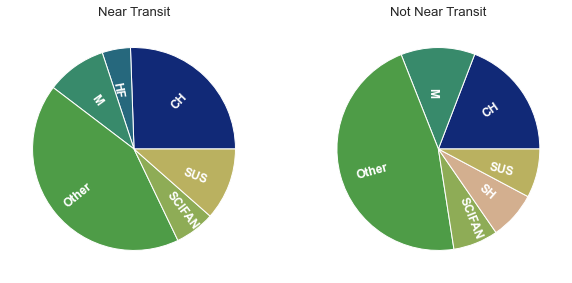

In [192]:
fig, axs = plt.subplots(1, 2, figsize=(10,5)) #tight_layout = True)
#fig.subplots_adjust(hspace=0.7, wspace=0.4)

key = {'Transit':(0,1),'Type':('Residential','Near Transit')}
key = pd.DataFrame.from_dict(key)

col = [0,1]
counter = 0
for loc in locs['location']: #For each type

    rownum = 0
    colnum = col[counter]
    def mypie(slices,labels,colors):

        colordict={}
        for l,c in zip(labels,colors):
            #print(l,c)
            colordict[l]=c
        #fig = plt.figure()
        #ax = fig.add_subplot(111)

        pie_wedge_collection = axs[colnum].pie(slices, labels=bkscatsumall[bkscatsumall['location']==loc]['newcat'], labeldistance=0.5, rotatelabels=True, textprops={'color':"w",'weight':"bold"})#, autopct=make_autopct(slices))

        for pie_wedge in pie_wedge_collection[0]:
            pie_wedge.set_edgecolor('white')
            pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])

        titlestring = loc

        axs[colnum].set_title(titlestring)
    
        return axs[colnum],pie_wedge_collection

    slices = bkscatsumall[bkscatsumall['location']==loc]['bkPerVol']
    axs[colnum], pie_wedge_collection = mypie(slices,labels,colors)
    #axs[rownum,colnum] = fig
    counter+=1

#Save figure 
#plt.savefig('../figures/piecharts.eps', dpi=300, format="eps")
#plt.savefig('../figures/piecharts.png', dpi=300, format="png")
#plt.show() #show all figures

## Chi Square to test for similarity

Do this with the books per volume, not percentage. Set up table with transit or not as index and categories as columns.

In [193]:
bkscatsumallSort.head(12)

location  newcat    bkPerVol       total
location                                                             
Near Transit     3       Near Transit   Other   44.419585  104.596959
                 0       Near Transit      CH   26.732771  104.596959
                 5       Near Transit     SUS   12.026609  104.596959
                 2       Near Transit       M   10.021877  104.596959
                 4       Near Transit  SCIFAN    6.672690  104.596959
                 1       Near Transit      HF    4.723427  104.596959
Not Near Transit 8   Not Near Transit   Other  120.721449  259.758731
                 6   Not Near Transit      CH   49.797255  259.758731
                 7   Not Near Transit       M   30.678147  259.758731
                 11  Not Near Transit     SUS   20.191959  259.758731
                 10  Not Near Transit      SH   19.775073  259.758731
                 9   Not Near Transit  SCIFAN   18.594847  259.758731

In [204]:
bkscatsumallSort['percent'] = bkscatsumallSort['bkPerVol']/bkscatsumallSort['total']
transitChi1 = bkscatsumallSort[bkscatsumallSort['location']=='Near Transit'][['newcat','percent']]
                          
transitChi2 = bkscatsumallSort[bkscatsumallSort['location']=='Not Near Transit'][['newcat','percent']]
bkstransit = pd.merge(transitChi1, transitChi2, on='newcat', how='outer').fillna(0)
bkstransit = bkstransit.rename(columns={'percent_x': 'nearTransit', 'percent_y': 'notNearTransit'})
bkstransit.head(10)

,newcat,nearTransit,notNearTransit
0,Other,0.424674,0.464745
1,CH,0.255579,0.191706
2,SUS,0.114980,0.077734
3,M,0.095814,0.118102
4,SCIFAN,0.063794,0.071585
5,HF,0.045158,0.000000
6,SH,0.000000,0.076129


In [206]:
#Set up table for Chi Square to compare genre proportion between locations
#Get row totals
#bkstransit['rowTotal'] = bkstransit['nearTransit'] + bkstransit['notNearTransit']
#Column totals
#transitTotal = bkstransit['nearTransit'].sum()
#resTotal = bkstransit['notNearTransit'].sum()
#totalbksPerVol =  transitTotal + resTotal
#bkstransit['expbkPerVol']= (transitTotal*resTotal['lfltotal'])/totBks #only need this if doing chisquare rather than chi2: expected value is row total times col total divided by grand total. Accounts for different number of books
test = bkstransit
test['nearTransit'] = test['nearTransit']*100
test['notNearTransit'] = test['notNearTransit']*100
test.head()


,newcat,nearTransit,notNearTransit
0,Other,42.467377,46.474453
1,CH,25.557885,19.170580
2,SUS,11.498048,7.773351
3,M,9.581423,11.810247
4,SCIFAN,6.379431,7.158507


In [207]:
juvChi = test[['nearTransit','notNearTransit']]
chi2, p, dof, ex = chi2_contingency(juvChi, correction=False) #using chi2 here rather than chisquare because including adult book rather than specifying distribution (expected values)
print("chi: ",chi2,"p-value: ",p)

#chisquare(bksauthorshood['count'],f_exp=bksauthorshood['expectedAoc'])

chi:  14.218298613422212 p-value:  0.027290467433599256


## Language

In [162]:
bks.head()

,yrpub,count,authorOfColor,nonPersonAuthor,neighborhood,collection,type,age,category1,category2,category1Code,languages,originalLang
0,1961,1,0,0,Phinney-Greenwood,Phinney-Green2,Fiction,Young Adult,Adventure,Null,ADV,English,NaN
1,2012,1,0,0,Phinney-Greenwood,Phinney-Green4,Fiction,Adult,Adventure,Null,ADV,English,English
2,1988,1,0,0,Laurelhurst,Laurelhurst4,Fiction,Young Adult,Adventure,Null,ADV,English,English
3,2015,1,0,0,Northgate,Northgate3,Fiction,Adult,Adventure,Religion,ADV,English,English
4,1992,1,0,0,Phinney-Greenwood,Phinney-Green3,Fiction,Young Adult,Adventure,Null,ADV,English,NaN


In [163]:
bks.originalLang.unique()

array([nan, 'English', 'Spanish', 'Akkadian', 'French', 'Japanese',
       'Latin', 'Arabic', 'German', 'Thai', 'Swedish', 'Chinese',
       'Undetermined'], dtype=object)

In [164]:
bkslang = bks.groupby(['languages'])['count'].sum().reset_index()

bkslang

,languages,count
0,English,954
1,"English, Achinese",2
2,"English, French",2
3,"English, Italian",1
4,"English, Spanish",1
5,"English, Undetermined",2
6,French,2
7,German,1
8,"Hindi, English",1
9,Japanese,1
